In [6]:
# TASK 1

import numpy as py
import matplotlib as mlp
import pandas as pd
import datetime

# Want to predit hospitalized_new
#We then find the maximum value of the normalized popularity across the entire published time range for that region, over all symptoms using the chosen time resolution (day/week). 
#We scale this maximum value to 100. 
#All the other values are mapped to proportionally smaller values (linear scaling) in the range 0-100.
#For example, in the weekly data the row labeled 2020-07-13 represents the search activity for the week of July 13 to July 19, 2020, inclusive.
# The COVID_hosp dataset starts at 2019-12-31, while the search_trends starts on 01-06 -> drop 1st 7 rows of COVID_hosp

# For new cases, take sum
# NEED TO CHANGE IT SO THAT IT MERGES EVERY 7 ENTRIES UNTIL THE END OF THE REGION CODE! WHEN IT STOPS!
# also there may not be an even number of entries...may not be divisible by 7

hosp_data = pd.read_csv("COVID_hospitalization_cases_2020-10-04.csv")
search_data = pd.read_csv("search_trends_2020-10-04.csv")
search_data['date'] =  pd.to_datetime(search_data['date'], format='%Y-%m-%d')
search_data.open_covid_region_code = search_data.open_covid_region_code.astype(str)

temp = hosp_data[['open_covid_region_code', 'date','hospitalized_new']].copy()
temp['date'] =  pd.to_datetime(temp['date'], format='%Y-%m-%d')
temp.open_covid_region_code = temp.open_covid_region_code.astype(str)

reg_codes = temp.open_covid_region_code.unique()
covid_hosp = pd.DataFrame()

search_start_week = {}
rc = ""

for index, row in search_data.iterrows():
    if row["open_covid_region_code"] != rc:
        rc = row["open_covid_region_code"]
        search_start_week[rc] = row["date"] 

rc = ""
hosp_start_week = {}
for index, row in temp.iterrows():
    if row["open_covid_region_code"] != rc:
        rc = row["open_covid_region_code"]
        hosp_start_week[rc] = row["date"]

for r in search_start_week.keys():
    while search_start_week[r] != hosp_start_week[r]:
        # search is by week +7
        # hosp is by day +1
        if search_start_week[r] > hosp_start_week[r]:
            hosp_start_week[r] += datetime.timedelta(days=1)
        else:
            search_start_week[r] += datetime.timedelta(days=7)

# now all dates should be equal

for reg in reg_codes:
    region = temp[temp.open_covid_region_code == reg]
    region = region[region.date >= hosp_start_week[reg]]
    region = region.reset_index(drop=True)
    count_nan = len(region.hospitalized_new) - region.hospitalized_new.count()
    if count_nan == len(region.hospitalized_new):
        continue
        # so ignoring the regions that have no hospitalized_new data at all
    region_hosp = region.hospitalized_new.copy()
    region = region.drop('hospitalized_new', axis=1)
    region = region.iloc[::7]
    region_hosp = region_hosp.groupby(region_hosp.index // 7).sum()
    region = region.reset_index(drop=True)
    region_hosp = region_hosp.reset_index(drop=True)
    region = pd.concat([region, region_hosp], axis=1, sort=False)
    covid_hosp = covid_hosp.append(region)

covid_hosp = covid_hosp.reset_index(drop=True)
print(covid_hosp.shape)



#column_locs = {hosp_data.columns.get_loc(c): c for idx, c in enumerate(hosp_data.columns)}
#print(column_locs)


covid_hosp.to_csv('covid_hosp.csv', sep=",")

# Joining two datasets

for col in search_data.columns.to_list():
    # If more 50% NaN -> delete column
    count_nan = len(search_data[col]) - search_data[col].count()
    if count_nan >= len(search_data[col])*0.50:
        search_data.drop(col, axis=1, inplace=True)

search_data.to_csv('clean_search_data.csv', sep=",")

search_and_hosp = pd.merge(search_data, covid_hosp, how='inner', on=['date','open_covid_region_code'])
search_and_hosp.to_csv('search_and_hosp.csv', sep=",")
print(search_and_hosp.shape)

#Cleaned data is stored in search_and_hosp.csv

/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
(5129, 3)
(465, 31)


In [7]:
# task2.1
#Visualize the evolution of popularity of various symptoms across dierent regions over time. Specically, you
#need to visualize how the distribution of search frequency of each symptom aggregated across dierent regions
#changes over time. You can only do these plots for some of the most popular symptoms

In [8]:
import numpy as np
import pandas as pd
from random import randrange
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import heapq
import matplotlib.pyplot as plt

In [9]:
symp = pd.read_csv("clean_search_data.csv")
symp_columns=symp.columns
#print(symp_columns)
symptom=[]
for x in enumerate(symp_columns):
    #print(x,type(x))
    if "symptom" in x[1]:
        symptom.append(x[1])
#print(len(symptom))
freq=[]
for name in enumerate(symptom):
    freq.append((name[1],symp[name[1]].sum()))
print(freq[0])
#select symptoms with highest 10 frequencies
top10=heapq.nlargest(10,freq,key=lambda x: x[1])

print(top10)

('symptom:Allergic conjunctivitis', 3180.14)
[('symptom:Aphonia', 8006.37), ('symptom:Viral pneumonia', 7777.33), ('symptom:Laryngitis', 6612.02), ('symptom:Crackles', 5345.14), ('symptom:Dysautonomia', 5243.75), ('symptom:Angular cheilitis', 5166.6), ('symptom:Shallow breathing', 4960.44), ('symptom:Ventricular fibrillation', 4820.93), ('symptom:Hemolysis', 4784.86), ('symptom:Rectal pain', 4581.469999999999)]


In [10]:
y_list=symp["sub_region_1"].values
x_list=symp["date"].values
z_list=symp[top10[0][0]].values
#print(x_list,type(x_list))
print(np.unique(y_list))
print(type(x_list[0]))
from datetime import datetime

datetime_object = datetime.strptime(x_list[0], "%Y-%m-%d")
print(datetime_object)
print(len(x_list),len(y_list))

['Alaska' 'Delaware' 'District of Columbia' 'Hawaii' 'Idaho' 'Maine'
 'Montana' 'Nebraska' 'New Hampshire' 'New Mexico' 'North Dakota'
 'Rhode Island' 'South Dakota' 'Vermont' 'West Virginia' 'Wyoming']
<class 'str'>
2020-01-06 00:00:00
608 608


In [11]:
#print(y_list)
#each group is 38
x_sticks=x_list[:38]
#x_list=np.arange(608)
y_sticks=y_list
y_number,y_index=pd.factorize(y_list)
#print(result)
print(len(y_index), len(y_list),len(x_list))
print(x_sticks)

16 608 608
['2020-01-06' '2020-01-13' '2020-01-20' '2020-01-27' '2020-02-03'
 '2020-02-10' '2020-02-17' '2020-02-24' '2020-03-02' '2020-03-09'
 '2020-03-16' '2020-03-23' '2020-03-30' '2020-04-06' '2020-04-13'
 '2020-04-20' '2020-04-27' '2020-05-04' '2020-05-11' '2020-05-18'
 '2020-05-25' '2020-06-01' '2020-06-08' '2020-06-15' '2020-06-22'
 '2020-06-29' '2020-07-06' '2020-07-13' '2020-07-20' '2020-07-27'
 '2020-08-03' '2020-08-10' '2020-08-17' '2020-08-24' '2020-08-31'
 '2020-09-07' '2020-09-14' '2020-09-21']


In [12]:
z_list=z_list.reshape(16,38)

In [13]:
def heatmap(data, row_labels, col_labels,title, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
     #              labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    #for edge, spine in ax.spines.items():
        #spine.set_visible(False)

    #ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    #ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    #ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)

    return im, cbar
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None),  ha="center", va="center")
            texts.append(text)

    return texts


<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/venv/lib/python3.7/site-packages/matplotlib/ticker.py:431: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  # Remove the CWD from sys.path while we load stuff.


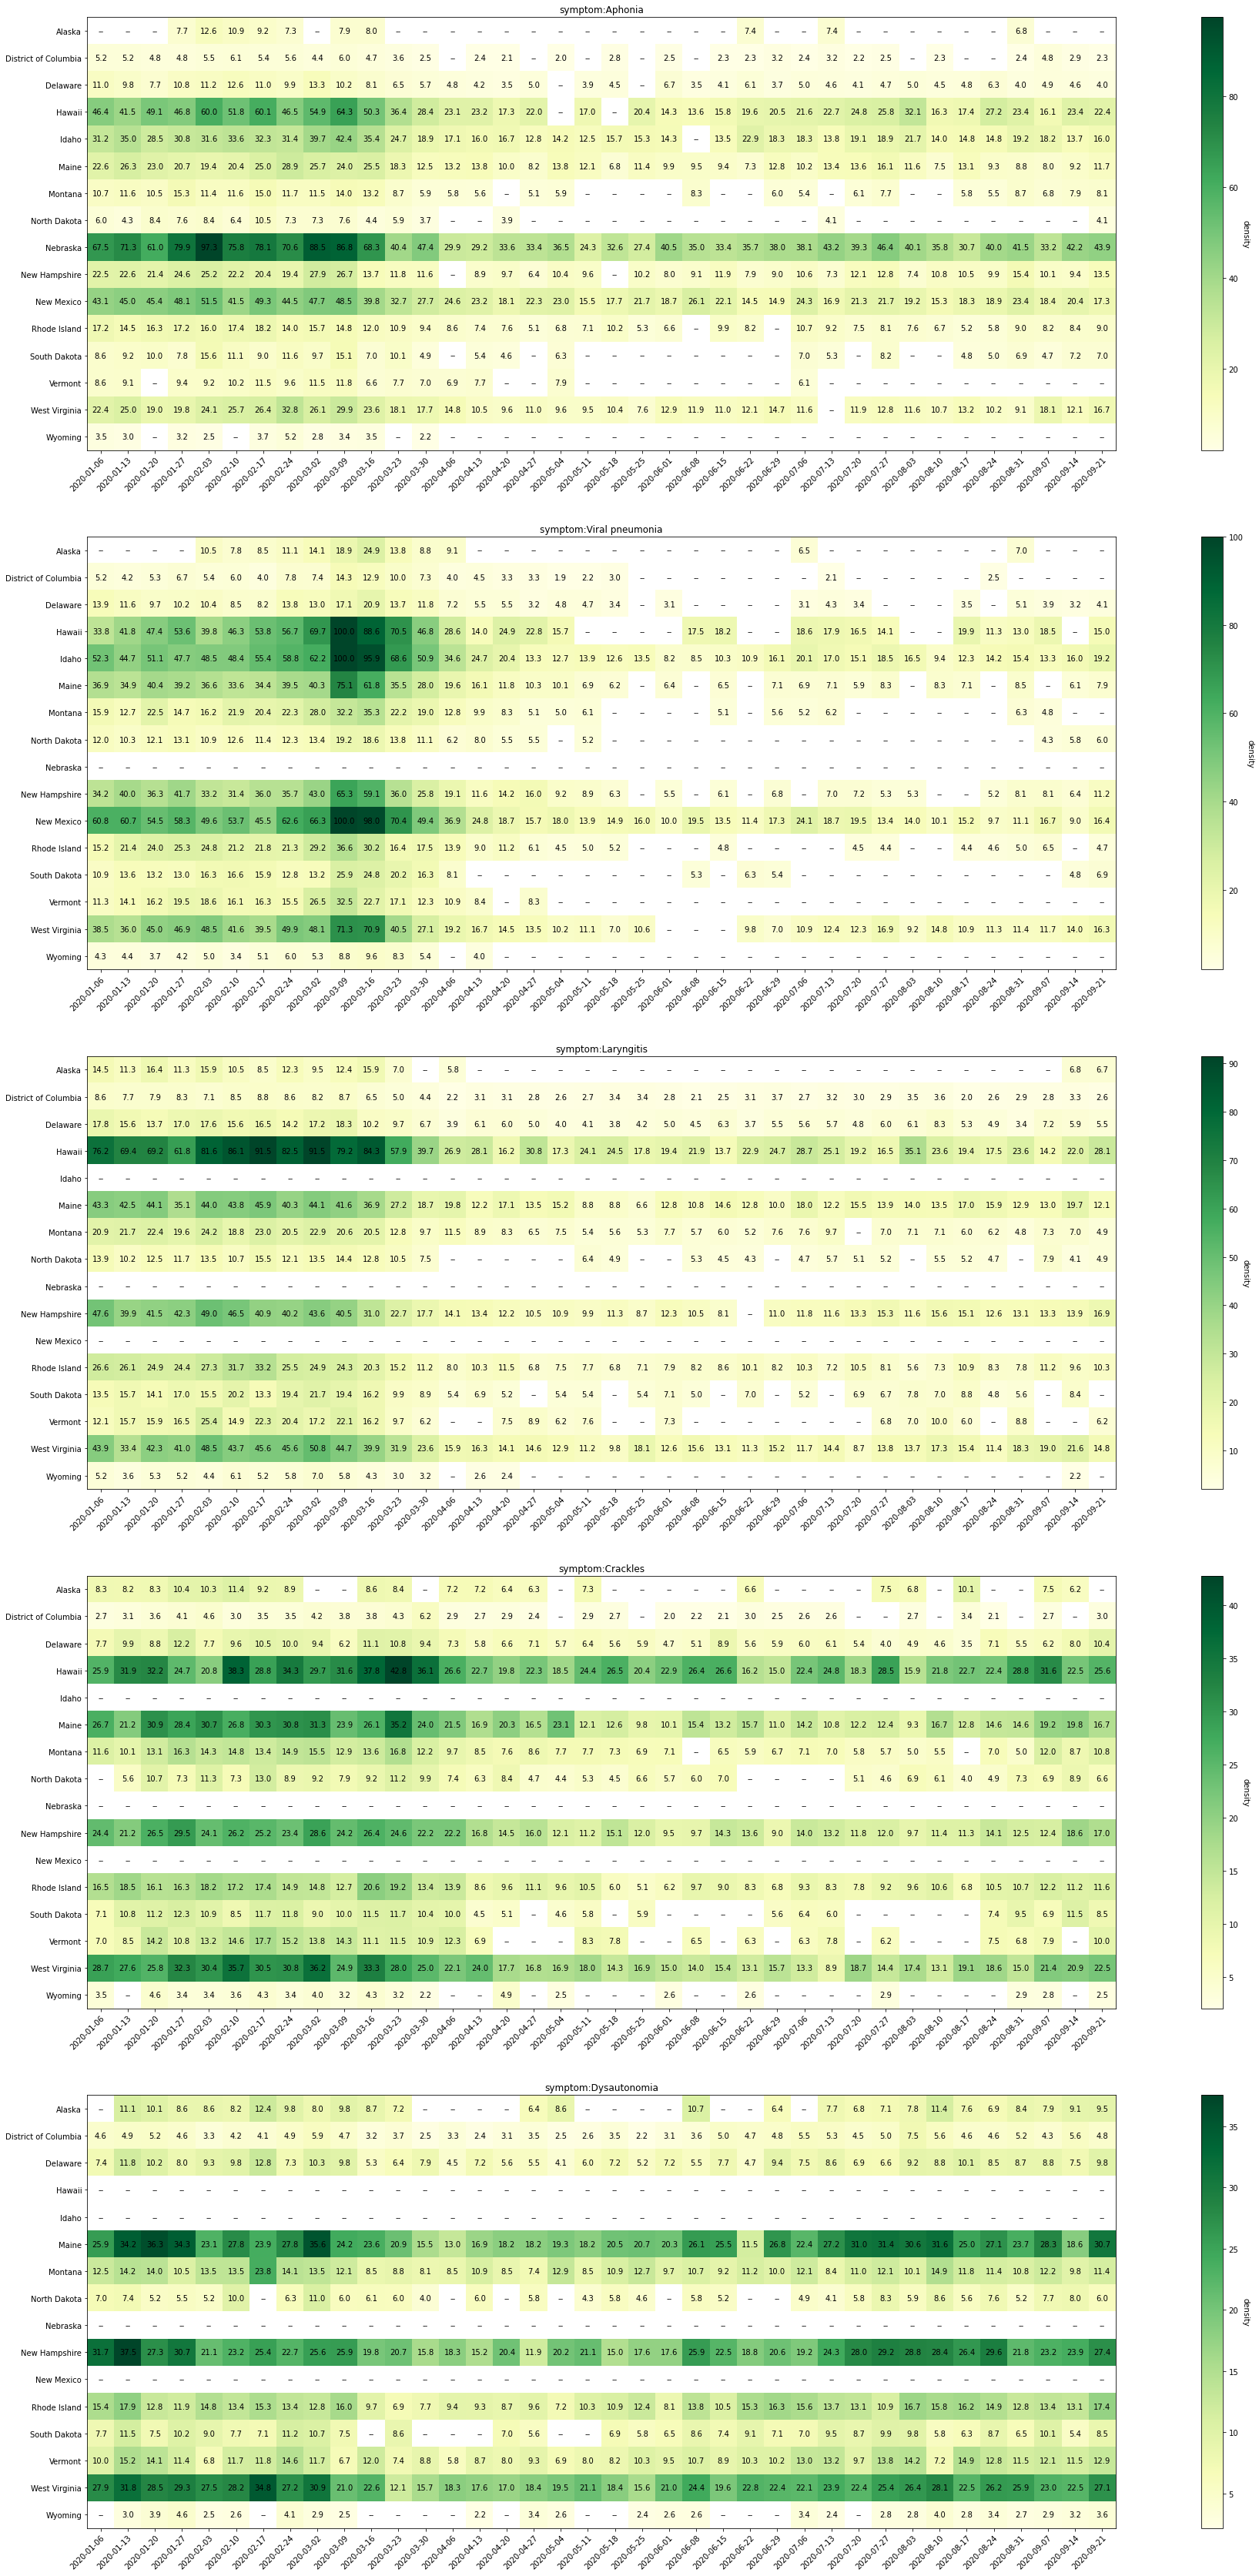

In [14]:
import matplotlib
fig, ax = plt.subplots(5)

for k in range(5):
    z_list=symp[top10[k][0]].values.reshape(16,38)
    
    im, _ = heatmap(z_list, y_index, x_sticks,top10[k][0], ax=ax[k],
                    cmap="YlGn", cbarlabel="density")
    annotate_heatmap(im, valfmt="{x:.1f}", size=60)
fig.tight_layout()
fig.set_size_inches(40, 60)
plt.show()

task 2.2 PCA

[[ 0.    0.    0.   ...  0.    9.91  0.  ]
 [ 0.    0.    0.   ...  7.65  8.41  0.  ]
 [ 0.    0.    0.   ...  7.54 16.19  0.  ]
 ...
 [ 2.2   2.25  0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  2.68  0.    0.  ]
 [ 0.    0.    0.   ...  0.    3.23  0.  ]]
[0.37229747 0.27685415 0.09454078 0.07579555 0.05887752 0.02888527
 0.02009354 0.01583652 0.01101536 0.00761596 0.00613592 0.00424111
 0.00381532 0.00326753 0.00309222 0.00282542 0.00242125 0.00232047
 0.00213003 0.00204427 0.00177804 0.00164226 0.00141158 0.00106245]


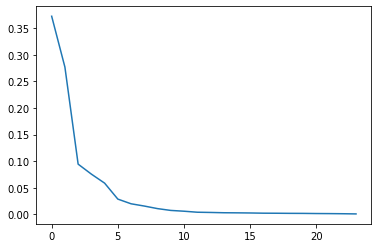

In [15]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
symp = pd.read_csv("clean_search_data.csv")
symp=symp.fillna(0)
x=symp.loc[:,'symptom:Allergic conjunctivitis':'symptom:Viral pneumonia'].values
print(x)
pca=PCA()
pca.fit(x)
x_reduced=pca.transform(x)

#find appropriate value of dimension 
plt.plot(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
#it looks like a decent amount of information was retained by the principal components 1 and 2

Text(0.5, 1.0, 'visulization of trends in low dimension space')

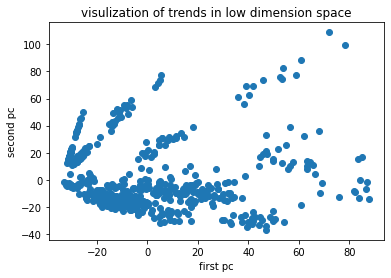

In [16]:
pca=PCA(n_components=6)
#pca.fit(x)
pac_line=pca.fit(x)
pac_line.explained_variance_ratio_
x_reduced=pca.transform(x)
plt.scatter(x_reduced[:,0],x_reduced[:,1])

plt.clim(-0.5,2.5)
plt.xlabel("first pc")
plt.ylabel("second pc")
plt.title("visulization of trends in low dimension space")

In [17]:
from sklearn.cluster import KMeans
from collections import Counter
for cluster in range(1,7):
    print(cluster)
    KMeans_high=KMeans(n_clusters=cluster,random_state=0)
    KMeans_high.fit(x)
    y_pred_high=KMeans_high.predict(x)
    print(Counter(y_pred_high))


    kmeans_low=KMeans(n_clusters=cluster,random_state=0)
    kmeans_low.fit(x_reduced)
    y_pred_low=kmeans_low.predict(x_reduced)
    print(Counter(y_pred_low))

#choose cluster number=4

1
Counter({0: 608})
Counter({0: 608})
2
Counter({0: 458, 1: 150})
Counter({0: 458, 1: 150})
3
Counter({0: 332, 2: 150, 1: 126})
Counter({0: 332, 2: 150, 1: 126})
4
Counter({0: 331, 2: 125, 3: 113, 1: 39})
Counter({2: 331, 3: 125, 1: 113, 0: 39})
5
Counter({3: 331, 1: 113, 0: 76, 2: 50, 4: 38})
Counter({1: 326, 2: 113, 0: 76, 3: 55, 4: 38})
6
Counter({0: 330, 5: 87, 2: 76, 4: 50, 1: 38, 3: 27})
Counter({1: 326, 5: 86, 0: 76, 3: 55, 4: 38, 2: 27})


In [18]:
KMeans_high=KMeans(n_clusters=3,random_state=0)
KMeans_high.fit(x)
y_pred_high=KMeans_high.predict(x)
    


kmeans_low=KMeans(n_clusters=3,random_state=0)
kmeans_low.fit(x_reduced)
y_pred_low=kmeans_low.predict(x_reduced)
   

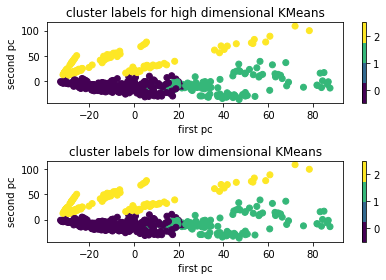

In [19]:

plt.subplot(2,1,1)
plt.scatter(x_reduced[:,0],x_reduced[:,1],c=y_pred_high,cmap=plt.cm.get_cmap('viridis',4))
plt.colorbar(ticks=[0,1,2,3])
plt.clim(-0.5,2.5)
plt.xlabel("first pc")
plt.ylabel("second pc")
plt.title("cluster labels for high dimensional KMeans")
plt.tight_layout()

plt.subplot(2,1,2)
plt.scatter(x_reduced[:,0],x_reduced[:,1],c=y_pred_low,cmap=plt.cm.get_cmap('viridis',4))
plt.colorbar(ticks=[0,1,2,3])
plt.clim(-0.5,2.5)
plt.xlabel("first pc")
plt.ylabel("second pc")
plt.title("cluster labels for low dimensional KMeans")
plt.tight_layout()


task 3.1 
Split data based on time

In [20]:
import numpy as np
import pandas as pd
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, neighbors

In [21]:
symp = pd.read_csv("search_and_hosp.csv")
symp=symp.fillna(0)
print(symp.shape)
num_instances=symp.shape[0]
#print(symp.columns.get_loc("symptom:Allergic conjunctivitis"))
x=symp.loc[:,'symptom:Allergic conjunctivitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
print(x.shape,x[0])
print(symp["open_covid_region_code"].unique())
print(len(symp["open_covid_region_code"].unique()))

(465, 32)
(465, 24) [11.61  0.    7.91  0.    0.    0.    0.    0.    0.    9.76  7.57  0.
 12.45  7.07  9.42  0.    7.57  7.07  8.58  8.08 13.97  0.    0.   18.85]
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-NM' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']
16


In [22]:
#split based on time, after 2020-08-10

all_col_index=[i for i in range(num_instances)]
test_date=['2020-08-10', '2020-08-17', '2020-08-24',
 '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21']
train_index=[]
test_index=[]
for i in all_col_index:
    #print(symp["date"].values[i])
    if symp["date"].values[i] not in test_date:
        train_index.append(i)
    else:
        test_index.append(i)

print(len(train_index),len(test_index))
print(train_index)

353 112
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 

In [23]:
#split the data by date 2020-08-10
#x_all_train, y_all_train are rows before 2020-08-10
x_all_train, y_all_train = x[train_index,:], y[train_index]
x_test,y_test=x[test_index,:],y[test_index]
print(x_test.shape,y_test.shape)
#divide the dates before 2020-08-10 to train and valid sets
n_test, n_valid = num_instances // 10, num_instances // 10
inds = np.random.permutation(len(train_index))
print(inds)
#x_valid, y_valid = x_all_train[inds[:n_valid]], y_all_train[inds[:n_valid]]
#x_train,y_train=x_all_train[inds[n_valid:]],y_all_train[inds[n_valid:]]
#print(x_valid.shape,x_test.shape,x_train.shape)

(112, 24) (112,)
[ 25 145 193  51 252 250 300 251 164  42 185 126  19 260 278  18 287  61
 138 249 171 161   0 104 310 218 281 308 265 335 174 321 331 163 154 303
 341 255 113 247 284  34 245 107 239 136 106  14 238   1  87 192 210 229
  15 330 305  56  85  41 304 146 316  98 214 299 242  81 224  59 162 302
 141  89 352   3 123  77 204  62 152  39 314 111 283  53 125 199  74 168
  80 235 112 344  38 246 184 142  44  66 244 340 288 269 209 124  86 134
 296 100 327  12   4 129 109 187  35 198 271 105 230 226 121   9 170  43
 102 259 191 219 346 150 128 267  48 320 275  49 266 325 234 311 324 122
 144  60 336 222  36 241 178 207 194 294 139  26  96 273 188 132  45 177
 228 263 225 183  24  23   8 206 201 227 332 339  20  11 108  82 338 277
 350 203 135 282 272 318 347 155 286 268 157 274  21  37  29 333  57 103
  92  31 254 270 114 232 147 298 329 258 200 231 253 343  32 291  46  17
  30 337  78 131 213   7  69 216 159 179 264 173 240  72 180  88 140 208
  65 196 211 115  64  28 116 190 1

KNN-validation test to pick k (time)

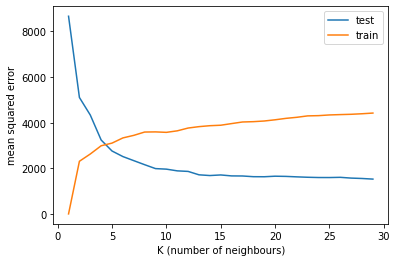

In [24]:
K_list = range(1,30)
err_train, err_test, err_valid = [], [], []
for i, K in enumerate(K_list):
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_all_train, y_all_train)
    err_test.append(np.mean((model.predict(x_test) - y_test)**2))
    #err_valid.append(np.mean((model.predict(x_valid) - y_valid)**2))
    err_train.append(np.mean((model.predict(x_all_train) - y_all_train)**2))
    
plt.plot(K_list, err_test,  label='test')
plt.plot(K_list, err_train,  label='train')
#plt.plot(K_list, err_valid, label='validation')

plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

#k=err_valid.index(min(err_valid))
#print(k)

In [25]:
model = neighbors.KNeighborsRegressor(n_neighbors=k)
model = model.fit(x_all_train, y_all_train)
y_predict=model.predict(x_test)

err_test=np.mean(np.sqrt(np.absolute(model.predict(x_test) - y_test)))
accuracy = np.sum(model.predict(x_test) == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}')
print("the mean square error is:", err_test)

accuracy is 19.6
the mean square error is: 4.417662180951715


split data based on region

In [26]:
symp = pd.read_csv("search_and_hosp.csv")
symp=symp.fillna(0)
print(symp.shape)
num_instances=symp.shape[0]
#print(symp.columns.get_loc("symptom:Allergic conjunctivitis"))
x=symp.loc[:,'symptom:Allergic conjunctivitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
print(x.shape,x[0])
print(symp["open_covid_region_code"].unique())
print(len(symp["open_covid_region_code"].unique()))


(465, 32)
(465, 24) [11.61  0.    7.91  0.    0.    0.    0.    0.    0.    9.76  7.57  0.
 12.45  7.07  9.42  0.    7.57  7.07  8.58  8.08 13.97  0.    0.   18.85]
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-NM' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']
16


In [27]:

all_col_index=[i for i in range(num_instances)]
unique_region=[]
for x in symp["open_covid_region_code"].unique():
    unique_region.append(x)
print(unique_region)
#block_index: list of list, each list is the indices of rows in the same region 
block_index=[]
for label in unique_region:
    block=[]
    for i in all_col_index:
        if symp["open_covid_region_code"].values[i] ==label:
            block.append(i)
    block_index.append(block)

print(len(block_index))

['US-AK', 'US-DC', 'US-DE', 'US-HI', 'US-ID', 'US-ME', 'US-MT', 'US-ND', 'US-NE', 'US-NH', 'US-NM', 'US-RI', 'US-SD', 'US-VT', 'US-WV', 'US-WY']
16


In [28]:
inds = np.random.permutation(num_instances)
x=symp.loc[:,'symptom:Allergic conjunctivitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
#predict the first region, training on the rest 15(?)
#x_test, y_test = x[block_index[-1]], y[block_index[-1]]
rest= sum(block_index, [])
x_rest, y_rest = x[rest], y[rest]
n_rest = num_instances - len(rest)

In [29]:


def cross_validate(n, block_index,n_folds=10):
    n_val = n // n_folds #floor divison, e.g. 15//2=7
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        tr_blk=[]
        val_blk=[]
        val_inds = list(range(f * n_val, (f+1)*n_val))
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        for i in tr_inds:
            tr_blk.append(block_index[i])
            #print("tr",tr_blk)
        tr_blk=sum(tr_blk,[])
        #print("after",tr_blk)
        for j in val_inds:
            val_blk.append(block_index[j])
        val_blk=sum(val_blk,[])
        yield tr_blk, val_blk

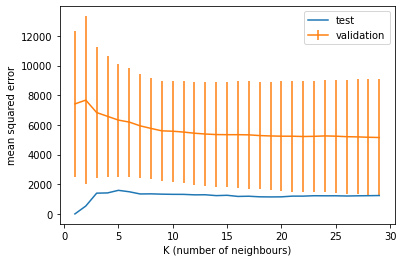

In [30]:
num_folds = 5
K_list=range(1,30)
err_test, err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))
accuracy=np.zeros(len(K_list))
loss = lambda y, yh: np.mean(np.square(np.absolute(y-yh)))
for i, K in enumerate(K_list):#try all possible k values
    for f, (tr, val) in enumerate(cross_validate(15, block_index,num_folds)):
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        
        
        model = model.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = loss(y_rest[val], model.predict(x_rest[val]))
    
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_rest, y_rest)
    err_test[i]= loss(y_test, model.predict(x_test))
    accuracy[i]=np.sum(model.predict(x_test) == y_test)/y_test.shape[0]
    
plt.plot(K_list, err_test,  label='test')
plt.errorbar(K_list, np.mean(err_valid, 1), np.std(err_valid, 1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()  


In [31]:
print(err_test)
print(accuracy)

[   0.          531.13169643 1399.01587302 1414.76841518 1589.33428571
 1493.35168651 1345.06905977 1352.51269531 1331.54354056 1319.59133929
 1316.81877214 1285.40215774 1290.13276627 1233.13957726 1255.41984127
 1178.7714495  1192.02907192 1152.97007275 1144.64995548 1150.79290179
 1199.05464448 1199.09435877 1225.47345058 1220.92912946 1222.21731429
 1207.29149937 1219.65445571 1228.30738657 1238.89335612]
[1.         0.24107143 0.22321429 0.19642857 0.19642857 0.19642857
 0.1875     0.1875     0.17857143 0.17857143 0.17857143 0.17857143
 0.17857143 0.16071429 0.13392857 0.125      0.11607143 0.10714286
 0.10714286 0.10714286 0.08928571 0.08928571 0.08035714 0.07142857
 0.04464286 0.         0.         0.         0.        ]


Task3.1 Decision Tree

splite the date based on regions

In [32]:
#split by regions 80% training and 20% test
from sklearn import tree
import pandas as pd

symp = pd.read_csv("search_and_hosp.csv")


splite based on time

In [51]:
#split the data by date 2020-08-10
from sklearn import tree
from sklearn import metrics 
import pandas as pd

symp = pd.read_csv("search_and_hosp.csv")
symp=symp.fillna(0)
print(symp.shape)
num_instances=symp.shape[0]
#print(symp.columns.get_loc("symptom:Allergic conjunctivitis"))
x=symp.loc[:,'symptom:Allergic conjunctivitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
print(x.shape,x[0])
print(symp["open_covid_region_code"].unique())
print(len(symp["open_covid_region_code"].unique()))

(465, 32)
(465, 24) [11.61  0.    7.91  0.    0.    0.    0.    0.    0.    9.76  7.57  0.
 12.45  7.07  9.42  0.    7.57  7.07  8.58  8.08 13.97  0.    0.   18.85]
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-NM' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']
16


In [52]:
#split based on time, after 2020-08-10

all_col_index=[i for i in range(num_instances)]
test_date=['2020-08-10', '2020-08-17', '2020-08-24',
 '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21']
train_index=[]
test_index=[]
for i in all_col_index:
    #print(symp["date"].values[i])
    if symp["date"].values[i] not in test_date:
        train_index.append(i)
    else:
        test_index.append(i)

print(len(train_index),len(test_index))
print(train_index)

353 112
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 

In [53]:
#split the data by date 2020-08-10
#x_all_train, y_all_train are rows before 2020-08-10
x_all_train, y_all_train = x[train_index,:], y[train_index]
x_test,y_test=x[test_index,:],y[test_index]

In [56]:
#initialzation the clf obj
clf= tree.DecisionTreeClassifier(criterion="entropy")
clf= clf.fit(x_all_train, y_all_train)
score= clf.score(x_test, y_test)


In [57]:
score


0.24107142857142858

In [58]:
!pip install graphviz==0.14.2

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [47]:
#display the tree

import graphviz
dot_data=tree.export_graphviz(clf
                            ,filled= True
                            ,rounded=True

)

graph= graphviz.Source(dot_data)
graph

ModuleNotFoundError: No module named 'graphviz'